In [115]:
import numpy as np
import json
from collections import defaultdict
import re
import matplotlib.pyplot as plt

## Load Wikipedia

In [2]:
WIKI_FILE_PATH = '../../../data/wiki_lookup.json'
wiki = json.load(open(WIKI_FILE_PATH))

## RAM Requirements

In [4]:
len(wiki.keys())

25808

We need to store a 25808x25808 matrix. Let's calculate how much RAM it takes to store this.

In [30]:
def ram_gb(r, c=None):
    if not c:
        c = r
    return (r*c*8) / 10**9

In [49]:
ram_gb(len(wiki.keys()))

5.328422912

In [114]:
ram_gb(7000000,100)

5.6

This matrix requires 5GB of RAM. This seems infeasible since Pagerank requires inversion, a very expensive matrix calculation. So we let's use a sparse matrix for now (since the number of entries in each row is far less than 25808).

## Matrix Format

Construct numeric index for each article

In [36]:
article_index = {}
index = 0
for article in wiki.keys():
    article_index[article] = index
    index += 1

In [120]:
counts = defaultdict(int)
for article in wiki.keys():
    counts[article.count('_')] += 1

<Container object of 15 artists>

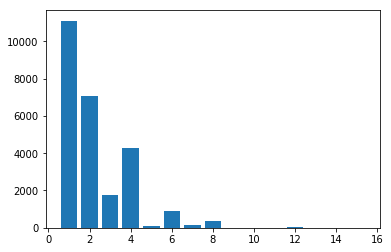

In [147]:
plt.bar(range(1,len(counts)+1), list(counts.values()), align='center')

In [144]:
.95*sum(counts.values())

24517.6

Construct page links

In [101]:
def clean_text(s):
    s = re.sub(r'[^\w\s]','',s)
    s = re.sub(r'[\n]',' ',s)
    return s

In [149]:
%%time
links = defaultdict(set)
progress = 0

for article in wiki.keys():
    
    progress += 1
    if progress % 1000 == 0:
        print(progress/len(wiki.keys()))
        
    p_word = ''
    pp_word = ''
    ppp_word = ''
    
    for word in filter(lambda x: x[0].isupper(), clean_text(wiki[article]['text']).split()):       
        if word in wiki.keys():
            links[article].add(word)

        bigram = str('_'.join([p_word, word]))
        if p_word and bigram in wiki.keys():
            links[article].add(bigram)
            
        trigram = str('_'.join([pp_word, p_word, word]))
        if pp_word and trigram in wiki.keys():
            links[article].add(trigram)
            
        quadgram = str('_'.join([ppp_word, pp_word, p_word, word]))
        if ppp_word and quadgram in wiki.keys():
            links[article].add(quadgram)
        
        ppp_word = pp_word
        pp_word = p_word
        p_word = word

0.03874767513949163
0.07749535027898326
0.1162430254184749
0.15499070055796652
0.19373837569745817
0.2324860508369498
0.2712337259764414
0.30998140111593303
0.34872907625542465
0.38747675139491633
0.42622442653440795
0.4649721016738996
0.5037197768133912
0.5424674519528828
0.5812151270923744
0.6199628022318661
0.6587104773713577
0.6974581525108493
0.7362058276503409
0.7749535027898327
0.8137011779293243
0.8524488530688159
0.8911965282083075
0.9299442033477991
0.9686918784872908
CPU times: user 1min 17s, sys: 500 ms, total: 1min 18s
Wall time: 1min 18s


Note that some articles such as 'A' are linked to even though these are not articles. This is okay because *insert ReLU explanation.*

In [156]:
links_count = {}
for article, linked_articles in links.items():
    links_count[article] = len(linked_articles)

In [166]:
sorted(links_count.items(), key=lambda x: x[1])[::-1]

[('England', 448),
 ('United_Kingdom', 447),
 ('United_States', 444),
 ('France', 431),
 ('History_of_the_United_States', 400),
 ('Russia', 390),
 ('Germany', 372),
 ('New_York_City', 355),
 ('List_of_recurring_The_Simpsons_characters', 355),
 ('Italy', 341),
 ('Italian_Americans', 341),
 ('Bob_Dylan', 333),
 ('Chicago', 328),
 ('Socialism', 327),
 ('Europe', 319),
 ('John_F._Kennedy', 316),
 ('Czech_Republic', 312),
 ('Greece', 312),
 ('Paris', 309),
 ('Antisemitism', 307),
 ('London', 307),
 ('Orson_Welles', 306),
 ('Theodore_Roosevelt', 305),
 ('World_War_I', 304),
 ('1970s', 304),
 ('Ronald_Reagan', 302),
 ('Pope_John_Paul_II', 300),
 ('Liverpool', 298),
 ('Manhattan', 296),
 ('Dwight_D._Eisenhower', 294),
 ('Israel', 290),
 ('Genoa', 289),
 ('Spain', 287),
 ('Protestantism', 286),
 ('Red', 285),
 ('Slavery', 285),
 ('Sculpture', 283),
 ('Puerto_Rico', 282),
 ('University_of_Oxford', 282),
 ('Winston_Churchill', 278),
 ('Baltimore', 277),
 ('Cold_War', 277),
 ('Christianity', 275),

In [167]:
%%time
matrix = []
for article in wiki.keys():
    row = [0]*(len(wiki.keys()))
    for entry in links[article]:
        row[article_index[entry]] = 1
    matrix.append(row)

CPU times: user 9.25 s, sys: 1.91 s, total: 11.2 s
Wall time: 11.3 s


In [168]:
%%time
M = np.array(matrix)

CPU times: user 35.3 s, sys: 2.96 s, total: 38.2 s
Wall time: 39.1 s


In [180]:
M[article_index['Adolf_Hitler']][article_index['Nazi_Germany']]

1